In [1]:
import torch
import copy
import numpy as np
from data_func import merge_files_and_split, ImageDataset, make_list, visualize_augmentations
from model import DownSample, DoubleConv, OutConv, UpSample, UNet
from utils import *
from model_v2 import *
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
from torch import optim, nn
import cv2
import time
import pandas as pd
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torch.optim import Adam
from torch import permute
from torch import nan_to_num
from torch.nn import BCEWithLogitsLoss
from torchvision.transforms import ToTensor
import rasterio
from torch import nn
from torch import optim, nn
from torch.utils.data import TensorDataset, DataLoader, Dataset
import os
from torch.nn import functional as F

os.environ["NO_ALBUMENTATIONS_UPDATE"] = "1"
import albumentations as A
import warnings
from torch.cuda.amp import autocast, GradScaler

warnings.filterwarnings("ignore", category=UserWarning, message="y_pred contains classes not in y_true")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import seaborn as sns

/Users/nadia/PycharmProjects/InterdisciplinaryProject/utils.py:105: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  grad_scaler = torch.cuda.amp.GradScaler()
/opt/anaconda3/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [2]:
# import sys
# del sys.modules['utils']

In [3]:
columns = [
    'epoch', 'train loss', 'valid loss', 'train_dice', 'train_l_dice', 'train_bal_acc',
    'train_l_bal_acc', 'val_dice', 'val_l_dice', 'val_l_bal_acc', 'val_bal_acc'
]

m1 = pd.read_csv('model_results1.txt', names=columns)
m2 = pd.read_csv('model_results2.txt', names=columns)
m3 = pd.read_excel('./model_results_off.xlsx')
m4 = pd.read_csv('model_results4_.txt', names=columns)

In [4]:
m1['val_dice'] = m1['val_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m1['train_dice'] = m1['train_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m1['val_l_dice'] = m1['val_l_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m1['train_l_dice'] = m1['train_l_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)

m2['val_dice'] = m2['val_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m2['train_dice'] = m2['train_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m2['val_l_dice'] = m2['val_l_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)
m2['train_l_dice'] = m2['train_l_dice'].str.extract(r'tensor\(([^)]+)\)')[0].astype(float)

m3['train_dice'] = pd.to_numeric(m3['train_dice'])
m3['val_dice'] = pd.to_numeric(m3['val_dice'])

m4['val_dice'] = m4['val_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)
m4['train_dice'] = m4['train_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)
m4['val_l_dice'] = m4['val_l_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)
m4['train_l_dice'] = m4['train_l_dice'].str.extract(r'tensor\((\d+\.\d+)')[0].astype(float)


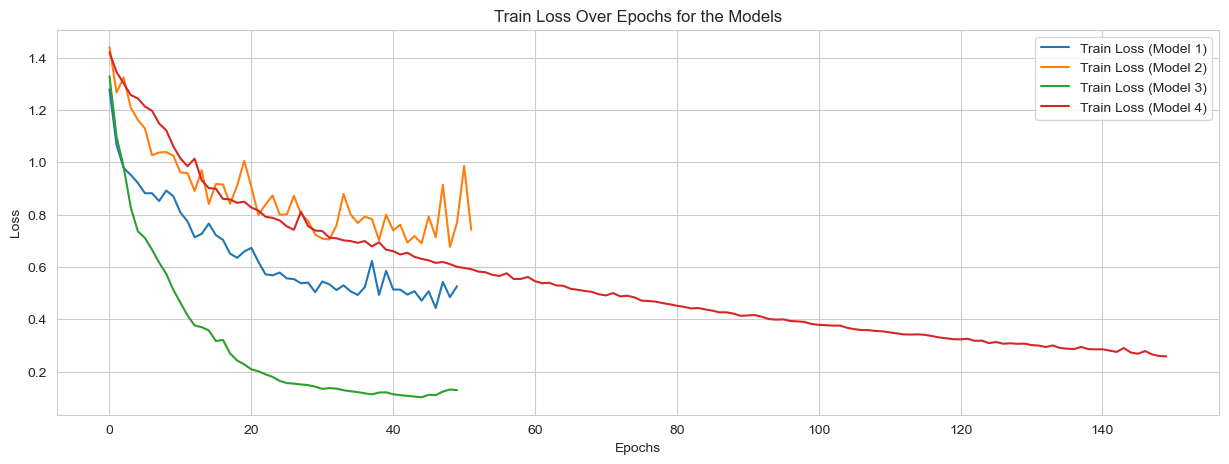

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(m1.index, m1['train loss'], label='Train Loss (Model 1)')
plt.plot(m2.index, m2['train loss'], label='Train Loss (Model 2)')
plt.plot(m3.index, m3['train_loss'], label='Train Loss (Model 3)')
plt.plot(m4.index, m4['train loss'], label='Train Loss (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs for the Models')
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


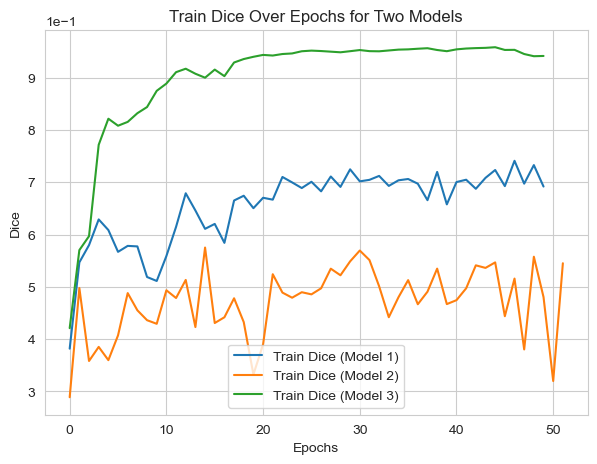

In [6]:
plt.figure(figsize=(7, 5))
plt.plot(m1.index, m1['train_dice'], label='Train Dice (Model 1)')
plt.plot(m2.index, m2['train_dice'], label='Train Dice (Model 2)')
plt.plot(m3.index, m3['train_dice'], label='Train Dice (Model 3)')
# plt.plot(m4.index, m4['train_dice'], label='Train Dice (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.title('Train Dice Over Epochs for Two Models')
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


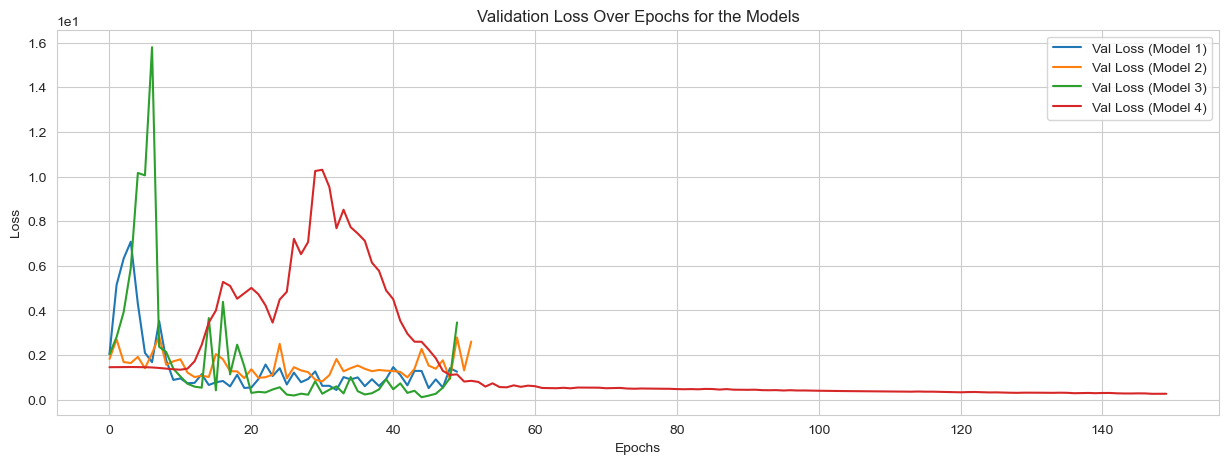

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(m1.index, m1['valid loss'], label='Val Loss (Model 1)')
plt.plot(m2.index, m2['valid loss'], label='Val Loss (Model 2)')
plt.plot(m3.index, m3['val_loss'], label='Val Loss (Model 3)')
plt.plot(m4.index, m4['valid loss'], label='Val Loss (Model 4)')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs for the Models')
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


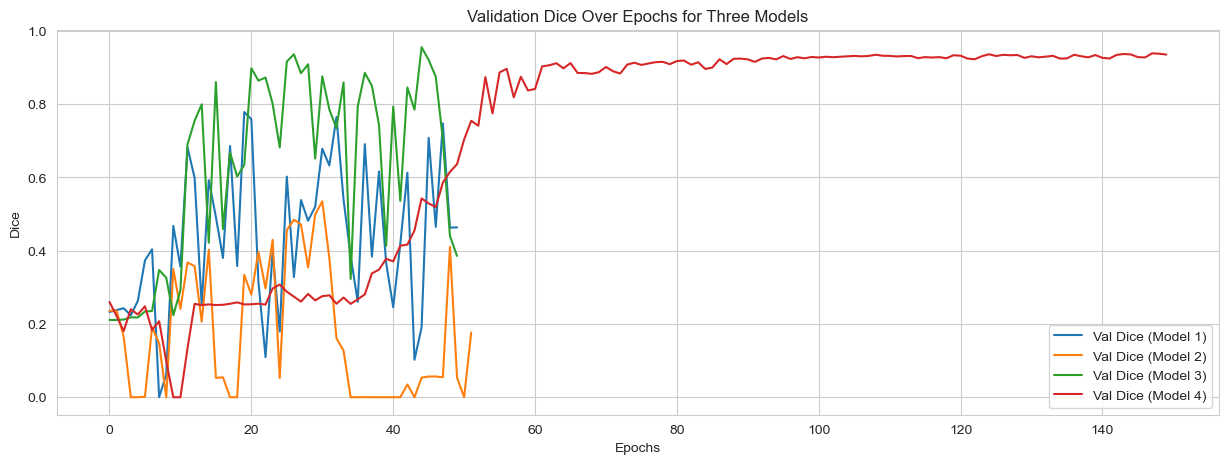

In [8]:
plt.figure(figsize=(15, 5))
plt.plot(m1.index, m1['val_dice'], label='Val Dice (Model 1)')
plt.plot(m2.index, m2['val_dice'], label='Val Dice (Model 2)')
plt.plot(m3.index, m3['val_dice'], label='Val Dice (Model 3)')
plt.plot(m4.index, m4['val_dice'], label='Val Dice (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.title('Validation Dice Over Epochs for Three Models')
plt.legend()
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


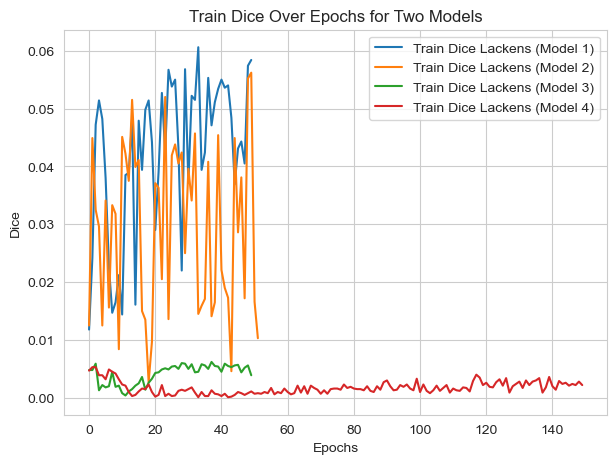

In [9]:
plt.figure(figsize=(7, 5))
plt.plot(m1.index, m1['train_l_dice'], label='Train Dice Lackens (Model 1)')
plt.plot(m2.index, m2['train_l_dice'], label='Train Dice Lackens (Model 2)')
plt.plot(m3.index, m3['train_l_dice'], label='Train Dice Lackens (Model 3)')
plt.plot(m4.index, m4['train_l_dice'], label='Train Dice Lackens (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.title('Train Dice Over Epochs for Two Models')
plt.legend()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


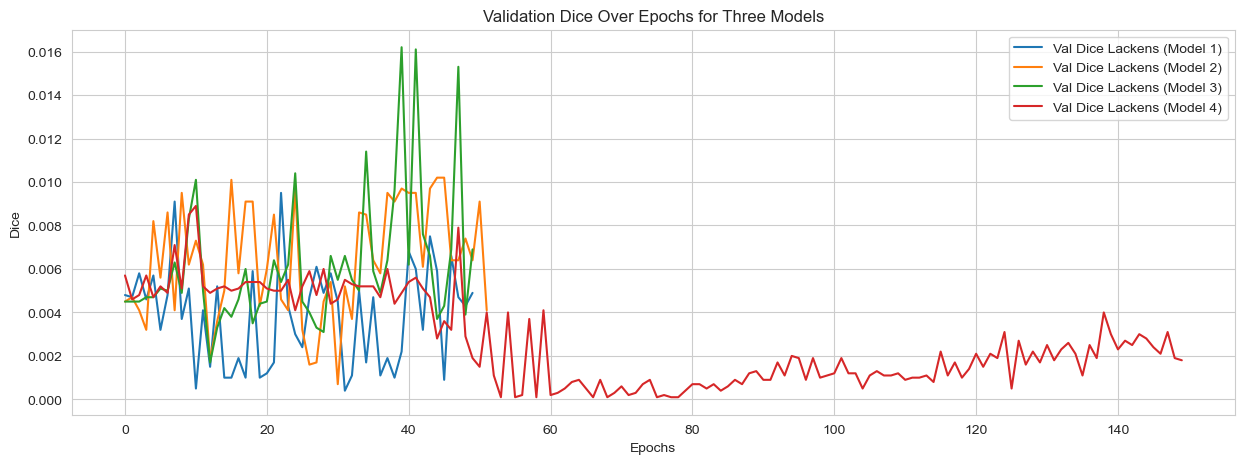

In [10]:
plt.figure(figsize=(15, 5))
plt.plot(m1.index, m1['val_l_dice'], label='Val Dice Lackens (Model 1)')
plt.plot(m2.index, m2['val_l_dice'], label='Val Dice Lackens (Model 2)')
plt.plot(m3.index, m3['val_l_dice'], label='Val Dice Lackens (Model 3)')
plt.plot(m4.index, m4['val_l_dice'], label='Val Dice Lackens (Model 4)')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.title('Validation Dice Over Epochs for Three Models')
plt.legend()
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.show()


In [11]:
m1_file = 'model1.pt'
m2_file = 'model2.pt'
m3_file = 'model3_old.pt'
m4_file = 'model4_.pt'

In [12]:
model1 = UNet(1, 1)
state_dict = torch.load(m1_file)  # Load the state_dict
model1.load_state_dict(state_dict)  # Load weights into the model
model1 = model1.to(device)
model1.eval()

/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_3699/3524046012.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(m1_file)  # Load the s

UNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DownSample(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [13]:
model2 = UNet(1, 1)
state_dict = torch.load(m2_file)  # Load the state_dict
model2.load_state_dict(state_dict)  # Load weights into the model
model2 = model2.to(device)
model2.eval()

/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_3699/1254520505.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(m2_file)  # Load the s

UNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DownSample(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [14]:
model3 = UNet(1, 1)
state_dict = torch.load(m3_file)  # Load the state_dict
model3.load_state_dict(state_dict)  # Load weights into the model
model3 = model3.to(device)
model3.eval()

/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_3699/2572230083.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(m3_file)  # Load the s

UNet(
  (inc): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): DownSample(
    (down): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=T

In [15]:

model4 = UNetFT(1)
state_dict = torch.load(m4_file)  # Load the state_dict
model4.load_state_dict(state_dict)  # Load weights into the model
model = model4.to(device)
model.eval()

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/var/folders/kj/50p9jhyx70135t3lmjp58l9h0000gn/T/ipykernel_3699/3064108098.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/py

UNetFT(
  (encoder1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (encoder2): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [16]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ], )
test_batch_size = 4
test_set = ImageDataset('./test/', './test_mask', './test_mask_lacken', test_transform)

testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=1)


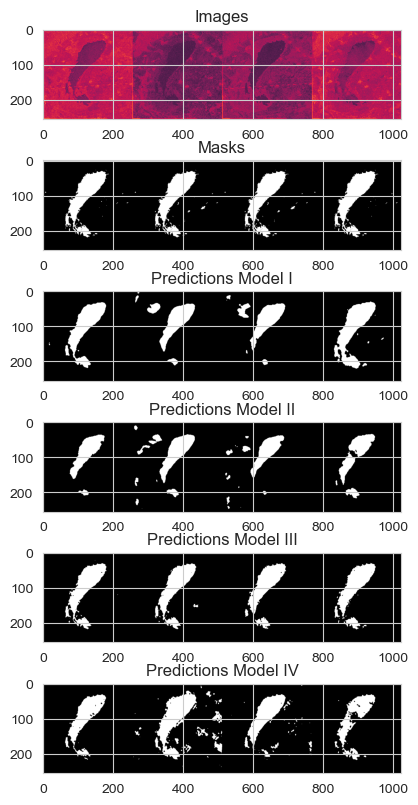

VV_2022-09-22_merged.tiff VV_mask_2022-09-22_merged.tif VV_mask_2022-04-11_merged_lacken_mask.tif
VH_2022-04-11_merged.tiff VH_mask_2022-04-11_merged.tif VV_mask_2022-09-22_merged_lacken_mask.tif
VH_2022-09-22_merged.tiff VV_mask_2022-04-11_merged.tif VH_mask_2022-04-11_merged_lacken_mask.tif
VV_2022-04-11_merged.tiff VH_mask_2022-09-22_merged.tif VH_mask_2022-09-22_merged_lacken_mask.tif


In [17]:
for images, masks, lacken_masks in testloader:
    with torch.no_grad():
        pred = model1(images.to(device)).detach()
        pred = (pred > 0.5).float()
        pred2 = model2(images.to(device)).detach()
        pred2 = (pred2 > 0.5).float()
        pred3 = model3(images.to(device)).detach()
        pred3 = (pred3 > 0.5).float()
        pred4 = model4(images.to(device)).detach()
        pred4 = (pred4 > 0.5).float()

    display_batch_all(images, masks, pred, pred2, pred3, pred4, lacken_masks, 1)

In [18]:
test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ], )
test_batch_size = 1
test_set = ImageDataset('./test/', './test_mask', './test_mask_lacken', test_transform)

testloader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size, shuffle=False, num_workers=1)


Dice Coefficient: 0.9098360538482666
Dice Coefficient Lackens: 0.00014753614959772676
IoU: 0.834597110748291
IoU Lackens: 0.00014753614959772676
Accuracy: 0.9211625456809998
Accuracy Lackens: 0.449660986661911
Correctly Identified Pixels: 64249/65536 (98.04%)
Correctly Identified Lake Pixels: 6493/7496 (86.62%)
Correctly Identified Lacken Pixels: 0/199 (0.00%)


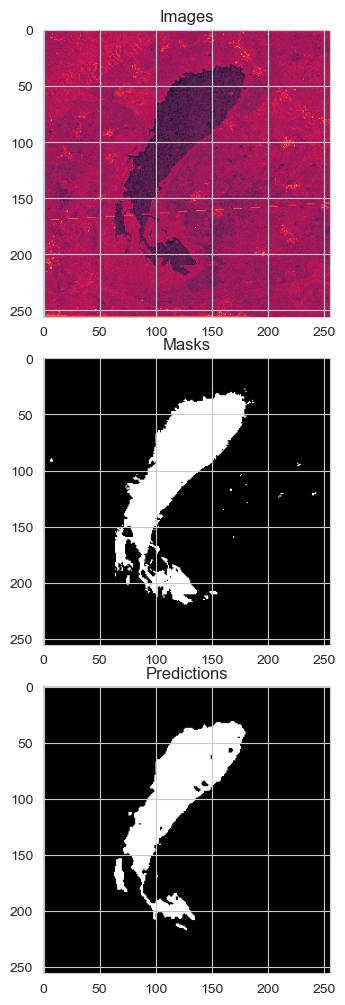

Dice Coefficient: 0.7830774784088135
Dice Coefficient Lackens: 0.000449761631898582
IoU: 0.6435055732727051
IoU Lackens: 0.0002699055476114154
Accuracy: 0.9407423734664917
Accuracy Lackens: 0.4266601502895355
Correctly Identified Pixels: 61452/65536 (93.77%)
Correctly Identified Lake Pixels: 7371/7710 (95.60%)
Correctly Identified Lacken Pixels: 2/92 (2.17%)


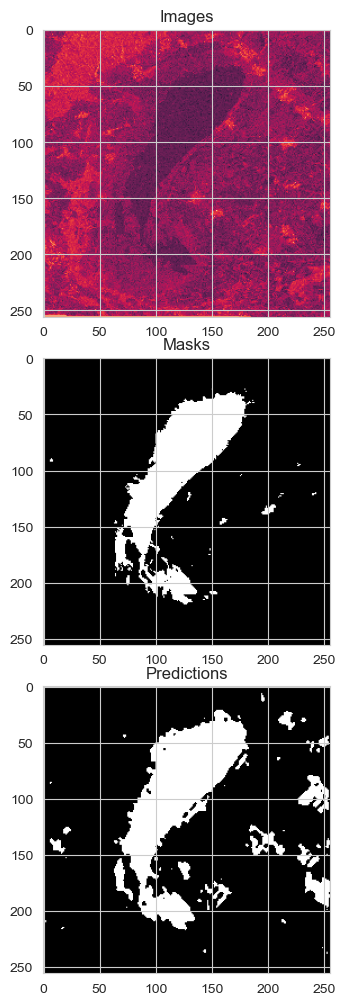

Dice Coefficient: 0.8678149580955505
Dice Coefficient Lackens: 0.00881236419081688
IoU: 0.7665094137191772
IoU Lackens: 0.00449346425011754
Accuracy: 0.9106326699256897
Accuracy Lackens: 0.52573162317276
Correctly Identified Pixels: 63556/65536 (96.98%)
Correctly Identified Lake Pixels: 6499/7603 (85.48%)
Correctly Identified Lacken Pixels: 32/199 (16.08%)


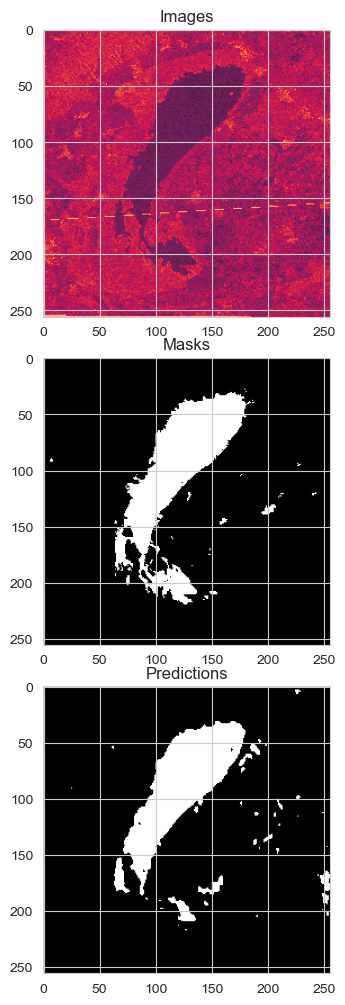

Dice Coefficient: 0.8496811389923096
Dice Coefficient Lackens: 0.00802643969655037
IoU: 0.7386646866798401
IoU Lackens: 0.0041080741211771965
Accuracy: 0.8823802471160889
Accuracy Lackens: 0.588225781917572
Correctly Identified Pixels: 63438/65536 (96.80%)
Correctly Identified Lake Pixels: 5929/7603 (77.98%)
Correctly Identified Lacken Pixels: 25/92 (27.17%)


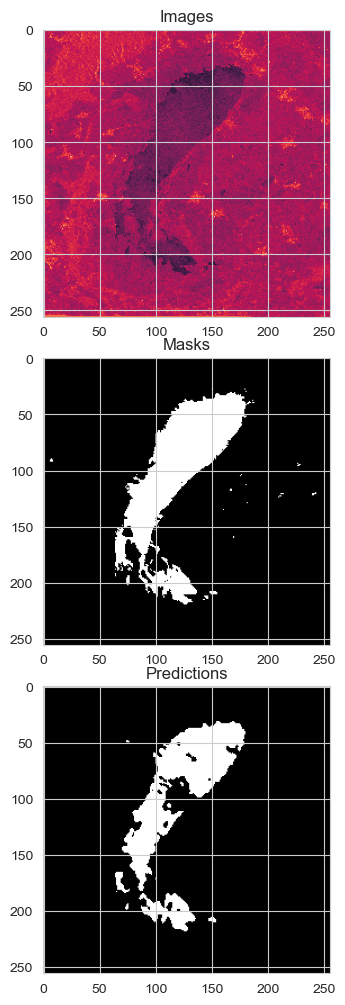

VV_2022-09-22_merged.tiff VV_mask_2022-09-22_merged.tif VV_mask_2022-04-11_merged_lacken_mask.tif
VH_2022-04-11_merged.tiff VH_mask_2022-04-11_merged.tif VV_mask_2022-09-22_merged_lacken_mask.tif
VH_2022-09-22_merged.tiff VV_mask_2022-04-11_merged.tif VH_mask_2022-04-11_merged_lacken_mask.tif
VV_2022-04-11_merged.tiff VH_mask_2022-09-22_merged.tif VH_mask_2022-09-22_merged_lacken_mask.tif


In [19]:

for images, masks, lacken_masks in testloader:
    with torch.no_grad():
        pred = model(images.to(device)).detach()
        pred = (pred > 0.5).float()

    display_batch(images, masks, pred, lacken_masks)

Dice Coefficient: 0.7848630547523499
Dice Coefficient Lackens: 0.0001932367158588022
IoU: 0.6459280252456665
IoU Lackens: 0.0001932367158588022
Accuracy: 0.8230409622192383
Accuracy Lackens: 0.4619281589984894
Correctly Identified Pixels: 62810/65536 (95.84%)
Correctly Identified Lake Pixels: 4972/7496 (66.33%)
Correctly Identified Lacken Pixels: 0/199 (0.00%)


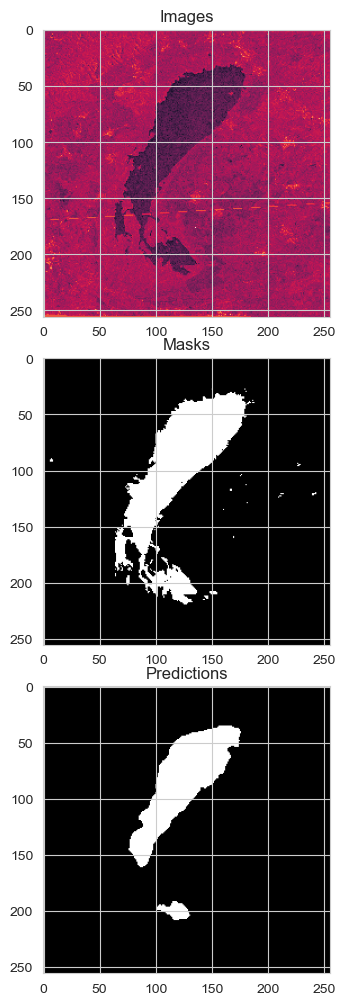

Dice Coefficient: 0.77072674036026
Dice Coefficient Lackens: 0.0001439884799765423
IoU: 0.626998245716095
IoU Lackens: 0.0001439884799765423
Accuracy: 0.8514586091041565
Accuracy Lackens: 0.44764989614486694
Correctly Identified Pixels: 62176/65536 (94.87%)
Correctly Identified Lake Pixels: 5647/7710 (73.24%)
Correctly Identified Lacken Pixels: 0/92 (0.00%)


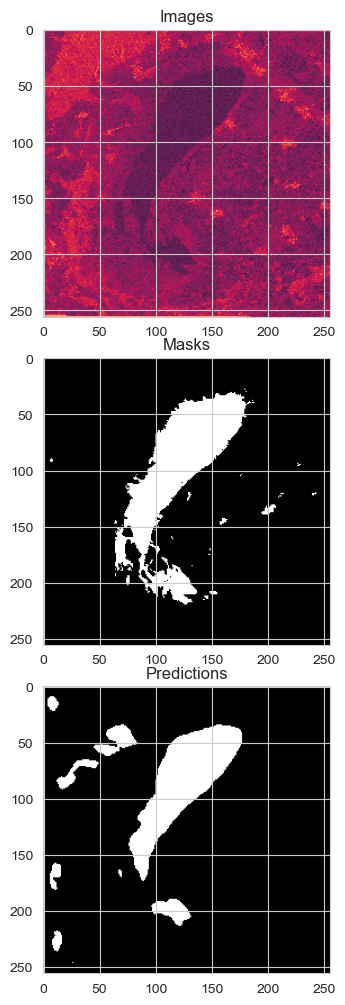

Dice Coefficient: 0.657040536403656
Dice Coefficient Lackens: 0.0001906941324705258
IoU: 0.48927783966064453
IoU Lackens: 0.0001906941324705258
Accuracy: 0.7633073329925537
Accuracy Lackens: 0.4614001214504242
Correctly Identified Pixels: 61130/65536 (93.28%)
Correctly Identified Lake Pixels: 4220/7603 (55.50%)
Correctly Identified Lacken Pixels: 0/199 (0.00%)


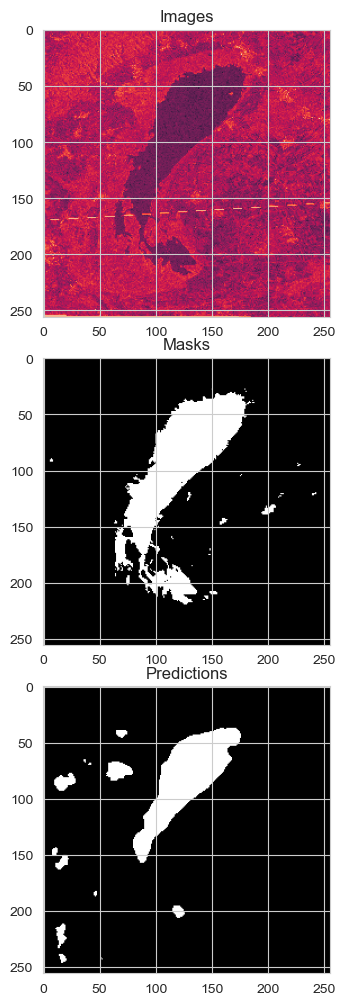

Dice Coefficient: 0.8278713226318359
Dice Coefficient Lackens: 0.00017924359417520463
IoU: 0.706316351890564
IoU Lackens: 0.00017924359417520463
Accuracy: 0.8542565703392029
Accuracy Lackens: 0.4580863118171692
Correctly Identified Pixels: 63267/65536 (96.54%)
Correctly Identified Lake Pixels: 5456/7603 (71.76%)
Correctly Identified Lacken Pixels: 0/92 (0.00%)


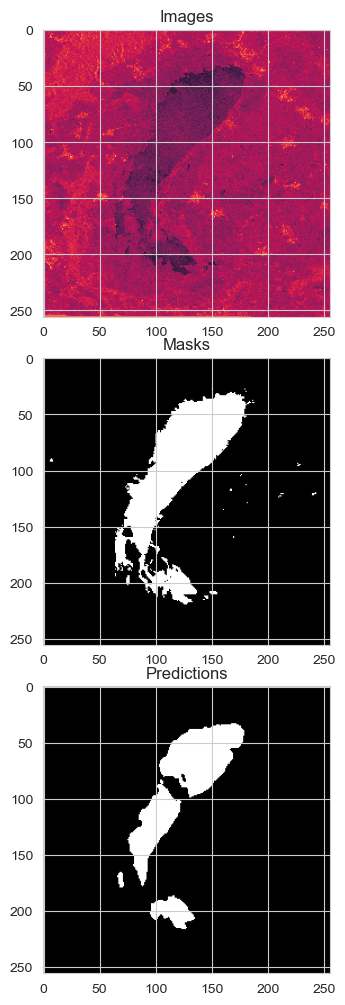

VV_2022-09-22_merged.tiff VV_mask_2022-09-22_merged.tif VV_mask_2022-04-11_merged_lacken_mask.tif
VH_2022-04-11_merged.tiff VH_mask_2022-04-11_merged.tif VV_mask_2022-09-22_merged_lacken_mask.tif
VH_2022-09-22_merged.tiff VV_mask_2022-04-11_merged.tif VH_mask_2022-04-11_merged_lacken_mask.tif
VV_2022-04-11_merged.tiff VH_mask_2022-09-22_merged.tif VH_mask_2022-09-22_merged_lacken_mask.tif


In [20]:

for images, masks, lacken_masks in testloader:
    with torch.no_grad():
        pred = model2(images.to(device)).detach()
        pred = (pred > 0.5).float()

    display_batch(images, masks, pred, lacken_masks)

Dice Coefficient: 0.9098360538482666
Dice Coefficient Lackens: 0.00014753614959772676
IoU: 0.834597110748291
IoU Lackens: 0.00014753614959772676
Accuracy: 0.9211625456809998
Accuracy Lackens: 0.449660986661911
Correctly Identified Pixels: 64249/65536 (98.04%)
Correctly Identified Lake Pixels: 6493/7496 (86.62%)
Correctly Identified Lacken Pixels: 0/199 (0.00%)


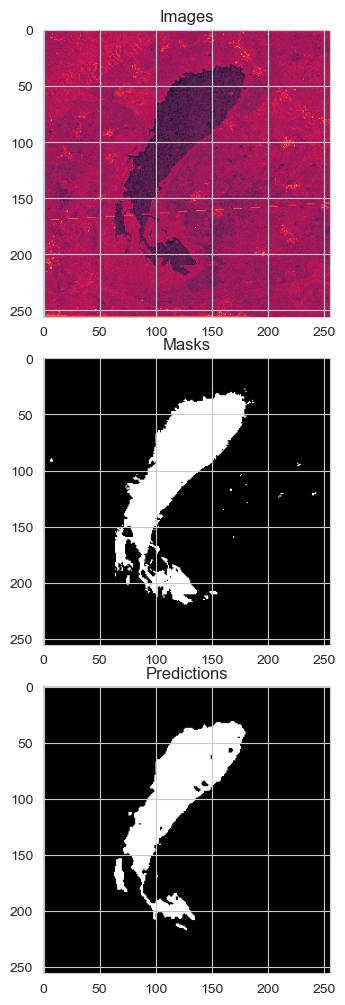

Dice Coefficient: 0.7830774784088135
Dice Coefficient Lackens: 0.000449761631898582
IoU: 0.6435055732727051
IoU Lackens: 0.0002699055476114154
Accuracy: 0.9407423734664917
Accuracy Lackens: 0.4266601502895355
Correctly Identified Pixels: 61452/65536 (93.77%)
Correctly Identified Lake Pixels: 7371/7710 (95.60%)
Correctly Identified Lacken Pixels: 2/92 (2.17%)


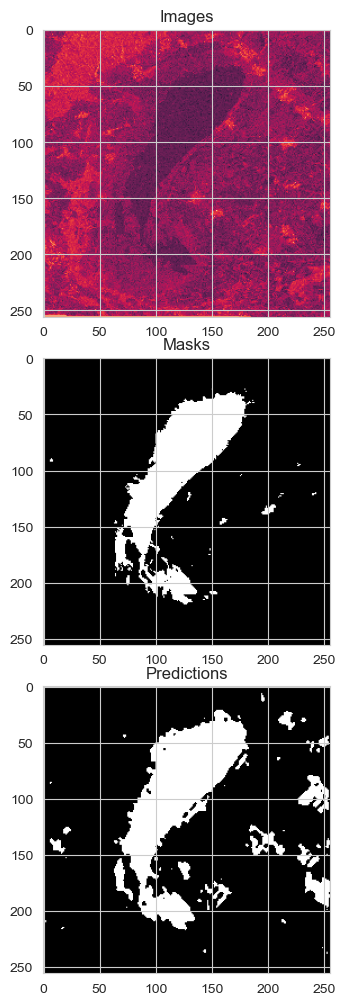

Dice Coefficient: 0.8678149580955505
Dice Coefficient Lackens: 0.00881236419081688
IoU: 0.7665094137191772
IoU Lackens: 0.00449346425011754
Accuracy: 0.9106326699256897
Accuracy Lackens: 0.52573162317276
Correctly Identified Pixels: 63556/65536 (96.98%)
Correctly Identified Lake Pixels: 6499/7603 (85.48%)
Correctly Identified Lacken Pixels: 32/199 (16.08%)


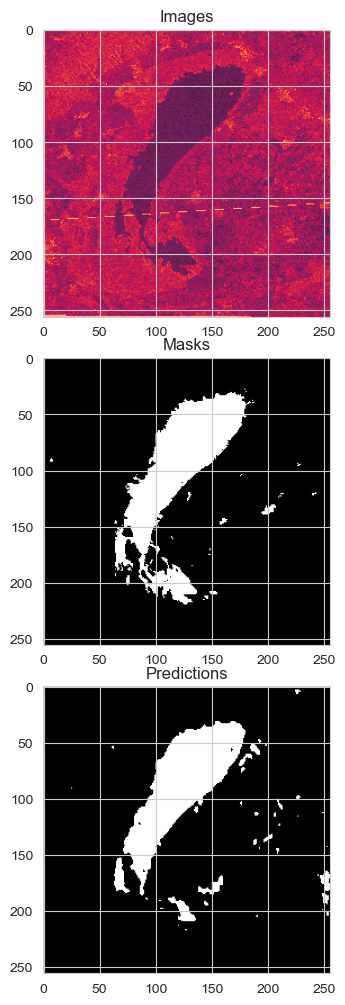

Dice Coefficient: 0.8496811389923096
Dice Coefficient Lackens: 0.00802643969655037
IoU: 0.7386646866798401
IoU Lackens: 0.0041080741211771965
Accuracy: 0.8823802471160889
Accuracy Lackens: 0.588225781917572
Correctly Identified Pixels: 63438/65536 (96.80%)
Correctly Identified Lake Pixels: 5929/7603 (77.98%)
Correctly Identified Lacken Pixels: 25/92 (27.17%)


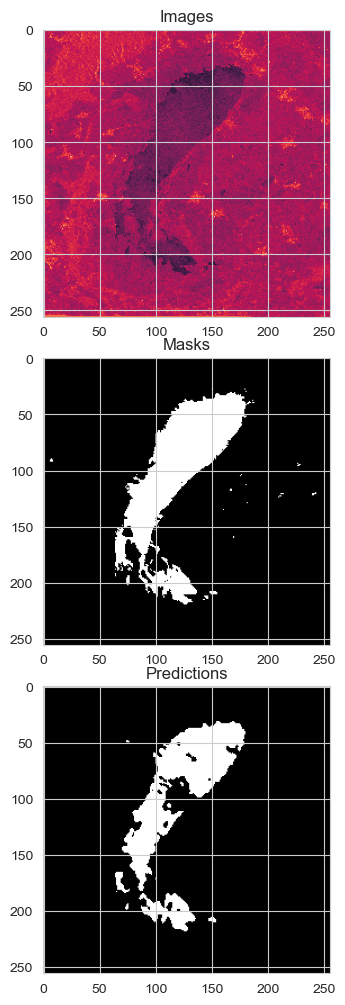

VV_2022-09-22_merged.tiff VV_mask_2022-09-22_merged.tif VV_mask_2022-04-11_merged_lacken_mask.tif
VH_2022-04-11_merged.tiff VH_mask_2022-04-11_merged.tif VV_mask_2022-09-22_merged_lacken_mask.tif
VH_2022-09-22_merged.tiff VV_mask_2022-04-11_merged.tif VH_mask_2022-04-11_merged_lacken_mask.tif
VV_2022-04-11_merged.tiff VH_mask_2022-09-22_merged.tif VH_mask_2022-09-22_merged_lacken_mask.tif


In [21]:
for images, masks, lacken_masks in testloader:
    with torch.no_grad():
        pred = model4(images.to(device)).detach()
        pred = (pred > 0.5).float()

    display_batch(images, masks, pred, lacken_masks)

Dice Coefficient: 0.9665607213973999
Dice Coefficient Lackens: 0.00433867983520031
IoU: 0.9352896213531494
IoU Lackens: 0.002239789115265012
Accuracy: 0.9732704162597656
Accuracy Lackens: 0.48364806175231934
Correctly Identified Pixels: 65031/65536 (99.23%)
Correctly Identified Lake Pixels: 7298/7496 (97.36%)
Correctly Identified Lacken Pixels: 16/199 (8.04%)


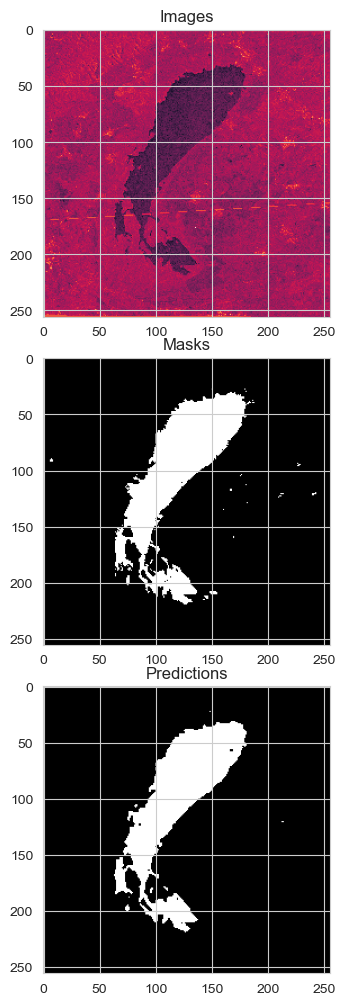

Dice Coefficient: 0.9401015639305115
Dice Coefficient Lackens: 0.002819170244038105
IoU: 0.8869803547859192
IoU Lackens: 0.001478693331591785
Accuracy: 0.9546131491661072
Accuracy Lackens: 0.4982234835624695
Correctly Identified Pixels: 64628/65536 (98.61%)
Correctly Identified Lake Pixels: 7125/7710 (92.41%)
Correctly Identified Lacken Pixels: 10/92 (10.87%)


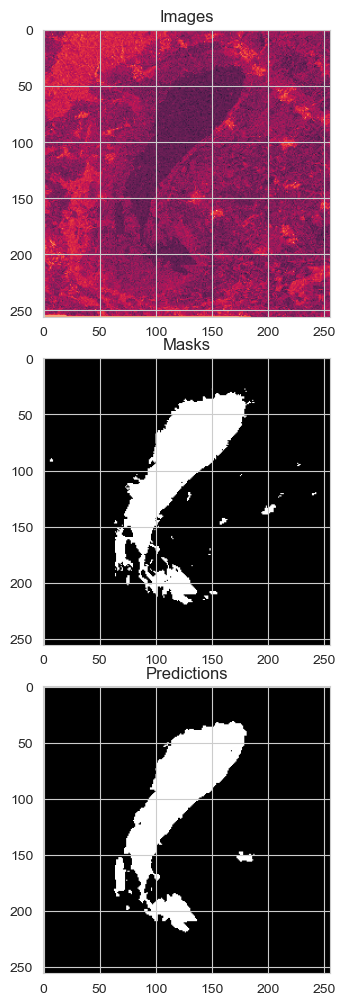

Dice Coefficient: 0.937559187412262
Dice Coefficient Lackens: 0.00013929516717325896
IoU: 0.8824653029441833
IoU Lackens: 0.00013929516717325896
Accuracy: 0.9436197876930237
Accuracy Lackens: 0.4465922713279724
Correctly Identified Pixels: 64613/65536 (98.59%)
Correctly Identified Lake Pixels: 6929/7603 (91.14%)
Correctly Identified Lacken Pixels: 0/199 (0.00%)


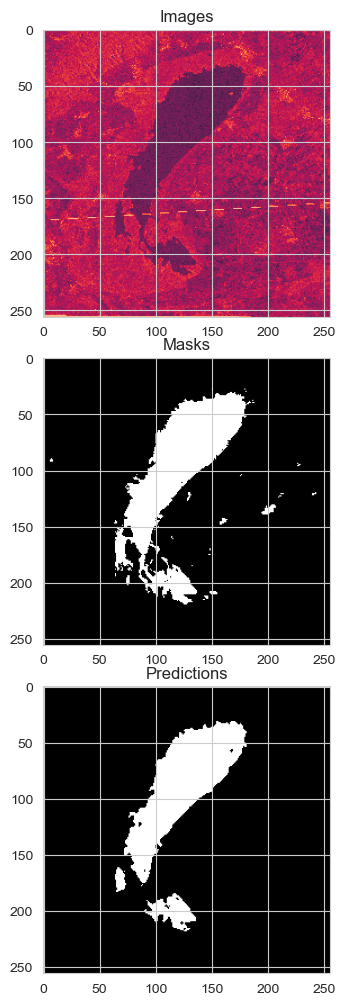

Dice Coefficient: 0.9545092582702637
Dice Coefficient Lackens: 0.01247484888881445
IoU: 0.912982702255249
IoU Lackens: 0.006343636196106672
Accuracy: 0.9654051661491394
Accuracy Lackens: 0.6941049098968506
Correctly Identified Pixels: 64851/65536 (98.95%)
Correctly Identified Lake Pixels: 7186/7603 (94.52%)
Correctly Identified Lacken Pixels: 46/92 (50.00%)


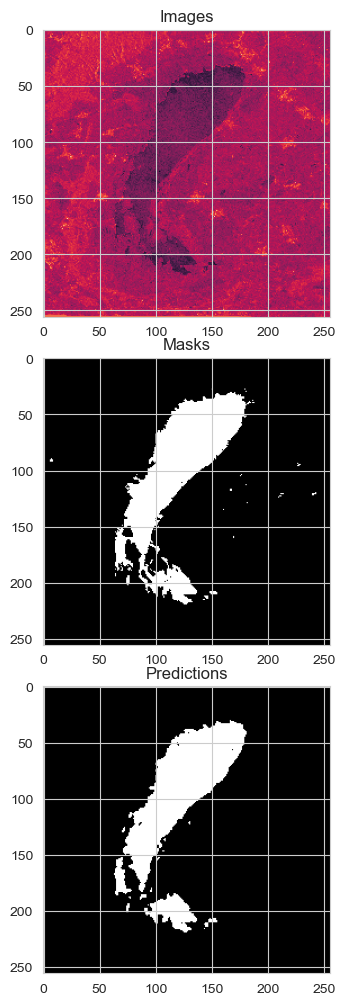

VV_2022-09-22_merged.tiff VV_mask_2022-09-22_merged.tif VV_mask_2022-04-11_merged_lacken_mask.tif
VH_2022-04-11_merged.tiff VH_mask_2022-04-11_merged.tif VV_mask_2022-09-22_merged_lacken_mask.tif
VH_2022-09-22_merged.tiff VV_mask_2022-04-11_merged.tif VH_mask_2022-04-11_merged_lacken_mask.tif
VV_2022-04-11_merged.tiff VH_mask_2022-09-22_merged.tif VH_mask_2022-09-22_merged_lacken_mask.tif


In [22]:
for images, masks, lacken_masks in testloader:
    with torch.no_grad():
        pred = model3(images.to(device)).detach()
        pred = (pred > 0.5).float()

    display_batch(images, masks, pred, lacken_masks)